<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/HUMAN_vs_AI_art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [29]:
# 1️⃣ Setup
!pip install timm lightgbm xgboost scikit-learn opencv-python pillow matplotlib seaborn kaggle --quiet


In [30]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Path to your kaggle.json in Google Drive
KAGGLE_JSON = "/content/drive/MyDrive/kaggle.json"  # <-- change if needed

import os
os.makedirs("/root/.kaggle", exist_ok=True)
!cp "{KAGGLE_JSON}" /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json


Mounted at /content/drive


In [31]:
!mkdir -p ./data/art_dataset
!kaggle datasets download -d kausthubkannan/ai-and-human-art-classification -p ./data/art_dataset
!unzip -q -n ./data/art_dataset/ai-and-human-art-classification.zip -d ./data/art_dataset/

Dataset URL: https://www.kaggle.com/datasets/kausthubkannan/ai-and-human-art-classification
License(s): DbCL-1.0
100% 2.20G/2.21G [01:17<00:00, 8.69MB/s]
100% 2.21G/2.21G [01:17<00:00, 30.5MB/s]


In [32]:
import pathlib, random, time
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image


In [43]:
# Dataset paths
DATA_ROOT = pathlib.Path("./data/art_dataset/ai_art_classification/train")
HUMAN_PATH = DATA_ROOT / "NON_AI_GENERATED"
AI_PATH    = DATA_ROOT / "AI_GENERATED"

assert HUMAN_PATH.exists() and AI_PATH.exists(), "Dataset folders not found!"

from itertools import islice
human_files = list(islice(HUMAN_PATH.glob("*.jpg"), 5000)) # taking only 5000 images
ai_files    = list(islice(AI_PATH.glob("*.jpg"), 5000)) # taking only 5000 images

all_files = human_files + ai_files
labels = [0]*len(human_files) + [1]*len(ai_files)

# Split: 64% train, 16% val, 20% test
train_files, test_files, train_labels, test_labels = train_test_split(
    all_files, labels, test_size=0.2, stratify=labels, random_state=42
)
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")


Train: 6400, Val: 1600, Test: 2000


# Handcrafted Feature Extraction

In [44]:
def extract_features(img_path):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (128,128))

    features = []

    # Color stats
    mean_colors = img_resized.mean(axis=(0,1))
    std_colors  = img_resized.std(axis=(0,1))
    features.extend(mean_colors)
    features.extend(std_colors)

    # Texture entropy
    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist /= hist.sum()
    entropy = -np.sum(hist*np.log2(hist+1e-7))
    features.append(entropy)

    # Edge density
    edges = cv2.Canny(gray,100,200)
    edge_density = edges.mean()
    features.append(edge_density)

    return np.array(features)

# Extract for all splits
X_train_hand = np.array([extract_features(f) for f in train_files])
X_val_hand   = np.array([extract_features(f) for f in val_files])
X_test_hand  = np.array([extract_features(f) for f in test_files])

# Scale features
scaler = StandardScaler()
X_train_hand = scaler.fit_transform(X_train_hand)
X_val_hand   = scaler.transform(X_val_hand)
X_test_hand  = scaler.transform(X_test_hand)


# Deep CNN Features (EfficientNet-B0)

In [45]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

cnn_model = models.efficientnet_b0(pretrained=True)
cnn_model.classifier = nn.Identity()  # Remove final classifier
cnn_model.eval().cuda()

def extract_cnn_features(file_list):
    feats = []
    with torch.no_grad():
        for f in file_list:
            img = Image.open(f).convert("RGB")
            x = transform(img).unsqueeze(0).cuda()
            feat = cnn_model(x).cpu().numpy().flatten()
            feats.append(feat)
    return np.array(feats)

X_train_cnn = extract_cnn_features(train_files)
X_val_cnn   = extract_cnn_features(val_files)
X_test_cnn  = extract_cnn_features(test_files)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Multi-Modal Ensemble

In [46]:
# Combine handcrafted + CNN
X_train = np.hstack([X_train_hand, X_train_cnn])
X_val   = np.hstack([X_val_hand, X_val_cnn])
X_test  = np.hstack([X_test_hand, X_test_cnn])

# Base classifiers
rf = RandomForestClassifier(n_estimators=200, random_state=42)
xgb_clf = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False)
lgbm_clf = lgb.LGBMClassifier()

for clf in [rf, xgb_clf, lgbm_clf]:
    clf.fit(X_train, train_labels)

# Stacking ensemble
val_preds = np.column_stack([rf.predict_proba(X_val)[:,1],
                             xgb_clf.predict_proba(X_val)[:,1],
                             lgbm_clf.predict_proba(X_val)[:,1]])

stacker = lgb.LGBMClassifier()
stacker.fit(val_preds, val_labels)

# Final test predictions
test_preds = np.column_stack([rf.predict_proba(X_test)[:,1],
                              xgb_clf.predict_proba(X_test)[:,1],
                              lgbm_clf.predict_proba(X_test)[:,1]])
final_preds = stacker.predict(test_preds)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:24:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 3200, number of negative: 3200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.198827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328440
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 1288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


# Evaluation

              precision    recall  f1-score   support

       Human       0.90      0.86      0.88      1000
          AI       0.86      0.91      0.88      1000

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



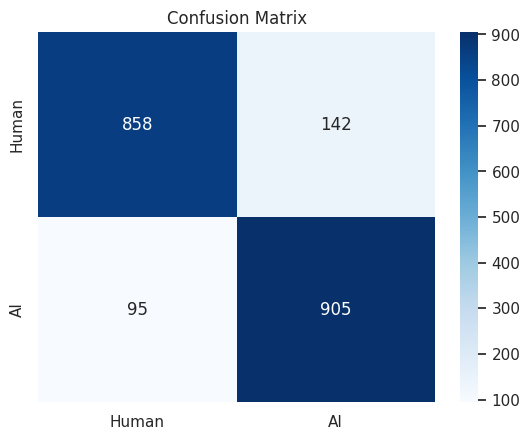

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


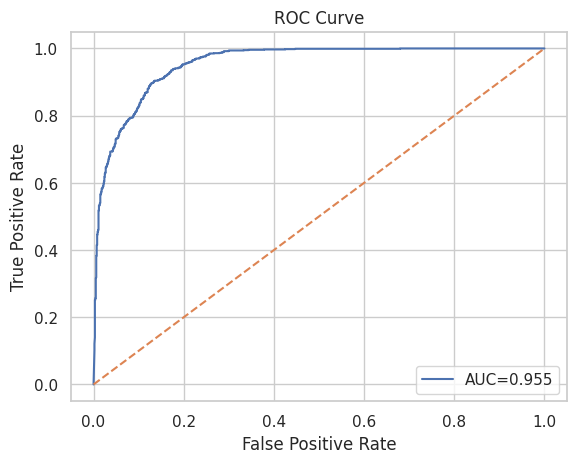

In [47]:
# Classification report
print(classification_report(test_labels, final_preds, target_names=["Human","AI"]))

# Confusion matrix
cm = confusion_matrix(test_labels, final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Human","AI"], yticklabels=["Human","AI"])
plt.title("Confusion Matrix")
plt.show()

# ROC curve
probs = stacker.predict_proba(test_preds)[:,1]
fpr, tpr, _ = roc_curve(test_labels, probs)
auc = roc_auc_score(test_labels, probs)
plt.plot(fpr,tpr,label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(); plt.show()


# Misclassified Examples

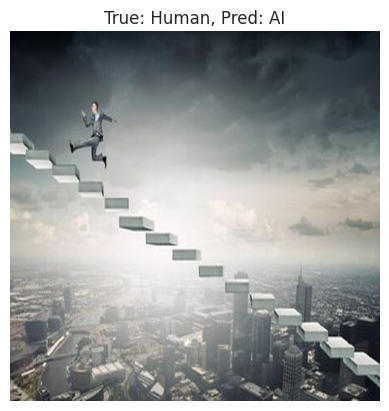

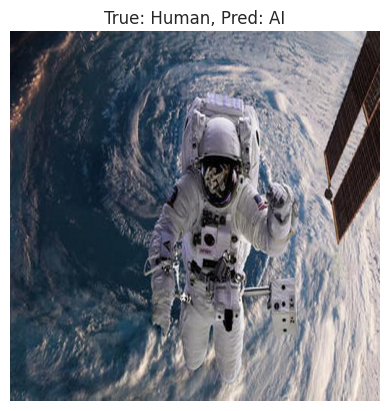

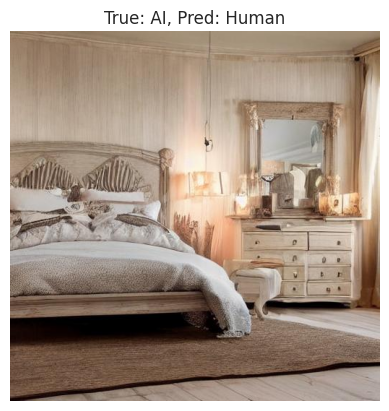

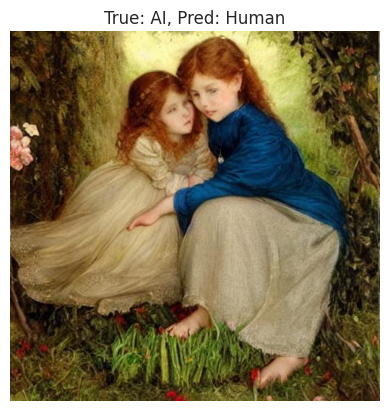

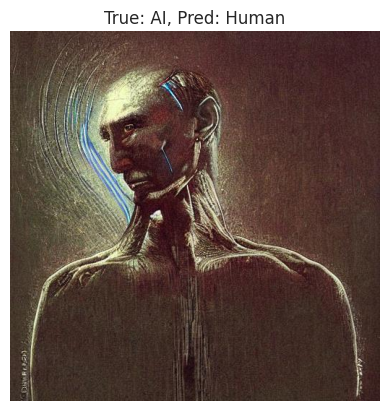

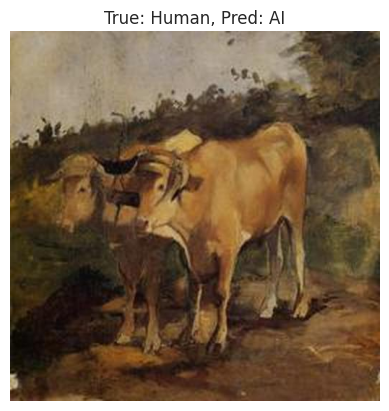

In [48]:
wrong_idx = [i for i,p in enumerate(final_preds) if p!=test_labels[i]]
random.shuffle(wrong_idx)

for i in wrong_idx[:6]:
    img = Image.open(test_files[i])
    plt.imshow(img)
    plt.title(f"True: {['Human','AI'][test_labels[i]]}, Pred: {['Human','AI'][final_preds[i]]}")
    plt.axis('off')
    plt.show()


# Feature Importance (Handcrafted + CNN Ensemble)

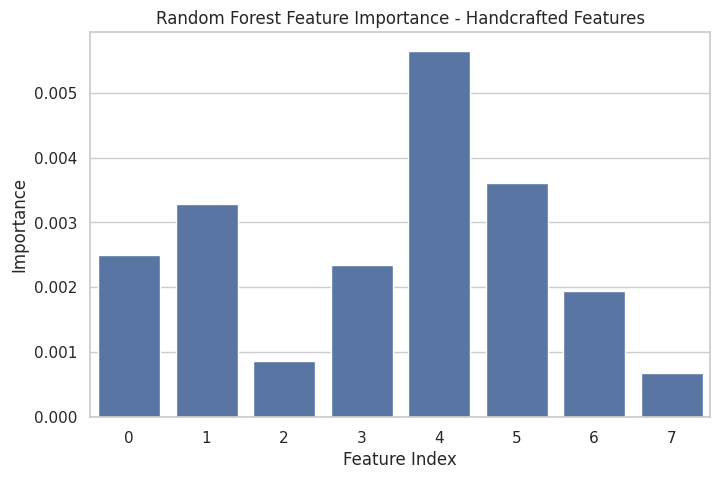

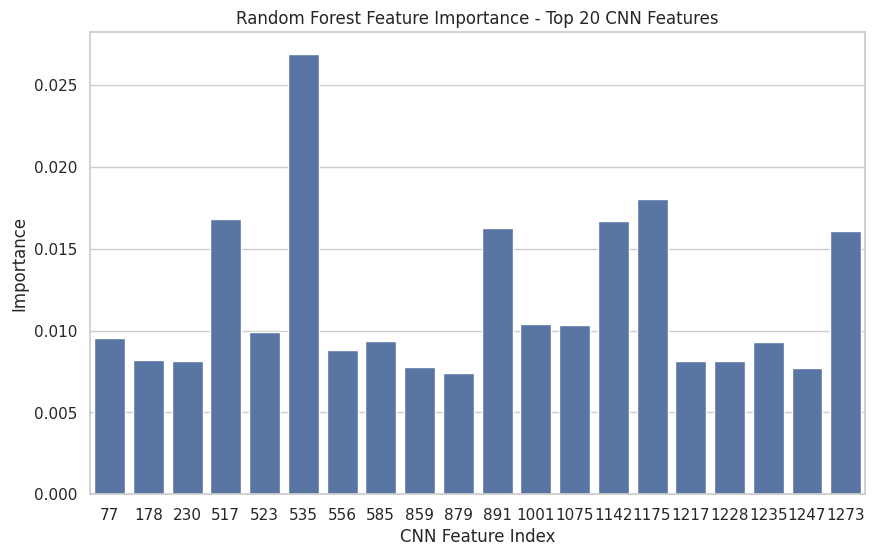

In [49]:
# Feature importance for Random Forest (handcrafted + CNN combined)
importances = rf.feature_importances_

# Split into handcrafted vs CNN features
num_hand = X_train_hand.shape[1]
hand_imp = importances[:num_hand]
cnn_imp  = importances[num_hand:]

# Plot top handcrafted features
plt.figure(figsize=(8,5))
sns.barplot(x=np.arange(len(hand_imp)), y=hand_imp)
plt.title("Random Forest Feature Importance - Handcrafted Features")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

# Plot top CNN features (show top 20)
top_idx = np.argsort(cnn_imp)[-20:]
plt.figure(figsize=(10,6))
sns.barplot(x=top_idx, y=cnn_imp[top_idx])
plt.title("Random Forest Feature Importance - Top 20 CNN Features")
plt.xlabel("CNN Feature Index")
plt.ylabel("Importance")
plt.show()


# UMAP Embedding of Test Set

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


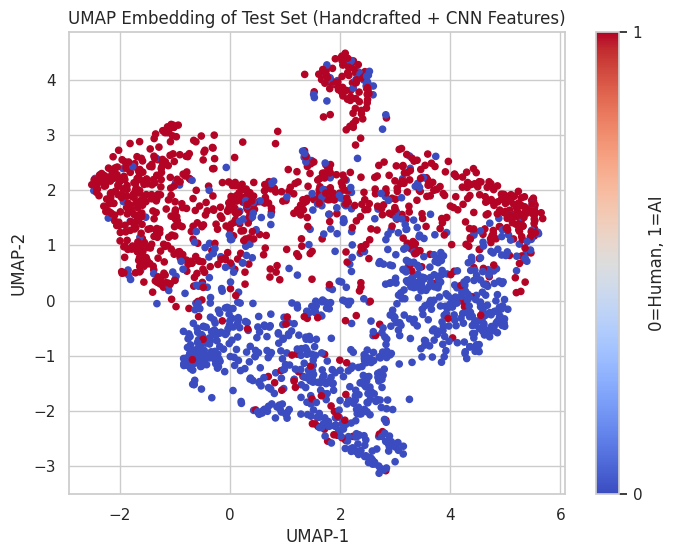

In [50]:
import umap

# Fit UMAP on combined features
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(np.hstack([X_test_hand, X_test_cnn]))

plt.figure(figsize=(8,6))
plt.scatter(embedding[:,0], embedding[:,1], c=test_labels, cmap='coolwarm', s=20)
plt.colorbar(ticks=[0,1], label='0=Human, 1=AI')
plt.title("UMAP Embedding of Test Set (Handcrafted + CNN Features)")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.show()


# Human vs AI Feature Comparison

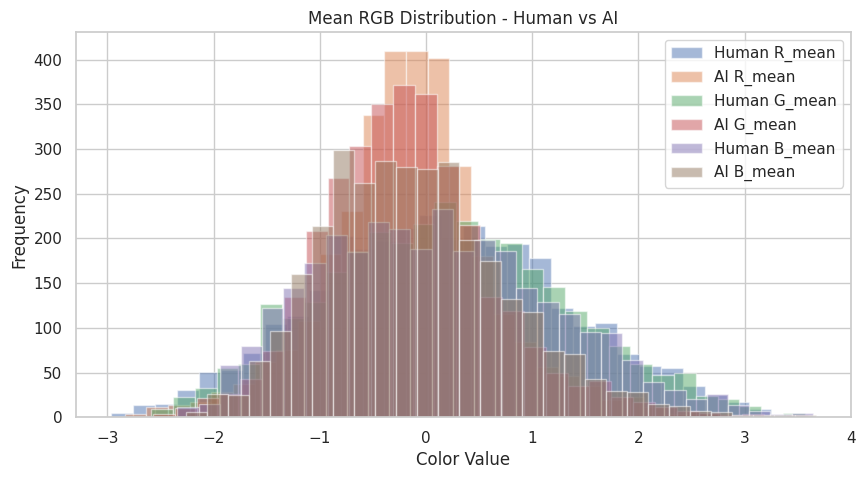

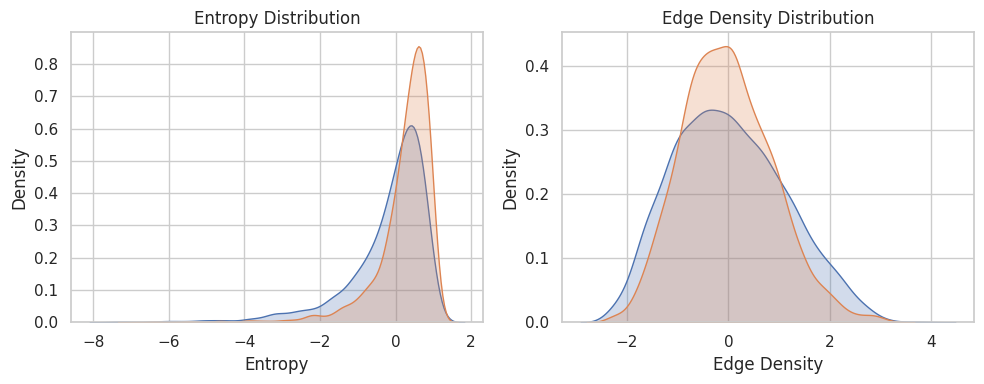

In [51]:
# Compare mean RGB color across Human vs AI images
hand_features_df = pd.DataFrame(X_train_hand, columns=[
    'R_mean','G_mean','B_mean','R_std','G_std','B_std','Entropy','EdgeDensity'
])
hand_features_df['Label'] = train_labels

# Separate Human vs AI
human_feat = hand_features_df[hand_features_df['Label']==0]
ai_feat    = hand_features_df[hand_features_df['Label']==1]

plt.figure(figsize=(10,5))
for i, color in enumerate(['R_mean','G_mean','B_mean']):
    plt.hist(human_feat[color], bins=30, alpha=0.5, label=f'Human {color}')
    plt.hist(ai_feat[color], bins=30, alpha=0.5, label=f'AI {color}')
plt.title("Mean RGB Distribution - Human vs AI")
plt.xlabel("Color Value"); plt.ylabel("Frequency")
plt.legend()
plt.show()

# Compare Entropy and Edge Density
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.kdeplot(human_feat['Entropy'], label='Human', fill=True)
sns.kdeplot(ai_feat['Entropy'], label='AI', fill=True)
plt.title("Entropy Distribution")
plt.xlabel("Entropy")

plt.subplot(1,2,2)
sns.kdeplot(human_feat['EdgeDensity'], label='Human', fill=True)
sns.kdeplot(ai_feat['EdgeDensity'], label='AI', fill=True)
plt.title("Edge Density Distribution")
plt.xlabel("Edge Density")

plt.tight_layout()
plt.show()
